# A Simple Python Library For System Dynamics

## Build System Dynamics simulations interactively in Jupyter using Python 

We love building computational models and our favorite environment for this kind of explorative, analytical work are [Jupyter](http://www.jupyter.org) and [Python](http://www.python.org).

To make computational modeling easier we are developing the _Business Prototyping Toolkit for Python_ (BPTK PY), a simple library that currently supports System Dynamics and Agent-based modeling.

We first introduced the BPTK PY libary in our recent post [Writing Computational Essays Based On Simulation Models](https://www.transentis.com/writing-computational-essays-based-simulation-models/).

Since then we've created some new functionality that allows you to build System Dynamics models and Agent-based models interactively in Jupyter using Python. To make model building as simple as possible, we have created a simple, domain-specific language (DSL) that supports both System Dynamics and Agent-based modeling and hides much of the underlying complexity of computational models.

This language not only allows you to create System Dynamics models and Agent-based models, you can even mix the two to create "hybrid" simulation models.

Having such a DSL is useful for several reasons:

* Build models interactively in Jupyter, making the modeling process very effective.
* Python novices can focus on the modeling, without needing to know much about Python
* Python experts can mix their models with other analytical frameworks, e.g. machine-learning toolkits.

Needless to say the new functionality seamlessly integrates with the rest of the BPTK PY framework, so you can use all the high-level scenario management and plotting functions which are part of the framework.

In this post I focus on how to build a System Dynamics model using the framework, I will take a look at Agent-based modeling in a future post.

### A simple model to demonstrate the library

To illustrate the DSL, we will build the simple project management model we introduced in our [step-by-step tutorial on System Dynamics](https://www.transentis.com/step-by-step-tutorials/introduction-to-system-dynamics/).

The project management model is really simple and just containts a few stocks, flows and converters, as you can see in the following diagram:

![Stock and Flow Diagram of the Simple Project Management Model](./sfd_simple_project_management.svg)

So even if you don't know the model you should be able to follow this post very easily.

To get started, we first need to import the library and in particular the SD function library into our notebook.

In [1]:
from BPTK_Py import Model
from BPTK_Py import sd_functions as sd

The SD function library contains the functions and operators needed to define model equations (these are the built-ins you will know from your visual modeling environment, such as Stella or Vensim). Because the library contains functions such as `min` and `max`, which are also part of the Python standard library, we import the SD function library with the prefix `sd` to avoid naming conflicts.

Next we create a model using the `Model` class. Our model will contain all our model elements such as stocks, flows, converters and constants.

In [2]:
model = Model(starttime=0.0,stoptime=120.0,dt=1.0,name='SimpleProjectManagament')

Creating model elements is really easy:

In [3]:
openTasks = model.stock("openTasks")

As you can see our convention is to use the camel casing naming convention for the model elements and to create Python variables for the elements that carry the same name.

Once a model element has been defined in this manner, we only need to refer to the Python variable and don't need to reference the model element (i.e. we can use `openTasks` in our equations, as opposed to using `model.stock("openTasks")`. This saves a lot of typing. 

Let's define the other model elements and variables now too, so that we can then concentrate on the equations:

In [4]:
closedTasks = model.stock("closedTasks")
staff = model.stock("staff")
completionRate = model.flow("completionRate")
currentTime = model.converter("currentTime")
remainingTime = model.converter("remainingTime")
schedulePressure = model.converter("schedulePressure")
productivity = model.converter("productivity")
deadline = model.constant("deadline")
effortPerTask = model.constant("effortPerTask")
initialStaff = model.constant("initialStaff")
initialOpenTasks = model.constant("initialOpenTasks")

Note that in our models we differentiate between _constants_ and _converters_ – this isn't strictly necessary from a System Dynamics point of view, but it makes it easier to check the model for errors.

Now let's initialize our stocks - to do this, we just need to set the `initial_value` property of the stocks. The initial value can either be a numerical constant or a constant element.

In [5]:
closedTasks.initial_value = 0.0
staff.initial_value = initialStaff
openTasks.initial_value = initialOpenTasks 

Defining the model equations is really easy: each model variable has an `equation` property, the equation itself is written much like you would in a visual modeling environment, using the other model variables as necessary.

Defining constants is particularly easy:

In [6]:
deadline.equation = 100.0
effortPerTask.equation = 1.0
initialStaff.equation = 1.0
initialOpenTasks.equation = 100.0

The `currentTime` variable tracks the simulation time, which is captured by the `time` function in the SD function library.

In [7]:
currentTime.equation=sd.time()

The `remainingTime` equals the difference between the `deadline` and the `currentTime`:

In [8]:
remainingTime.equation = deadline - currentTime

So you see, thanks to the DSL defining equations is very intuitive!

The equations for the stocks are also really simple - they just contain the inflows (with a positive sign) and the outflows (with a negative sign). 

A quick look at the diagram above tells us that the `openTasks` only have an outflow (defined by the `completionRate`) and the `closedTasks` only have an inflow (also defined by the `completionRate`):

In [9]:
openTasks.equation = -completionRate

In [10]:
closedTasks.equation = completionRate

The `schedulePressure` is a dimensionless ratio that compares the required effort to complete all remaining open tasks to the remaining work capacity.

We use the  `min` and `max` functions from the SD function library to ensure that no division by zero occurs and that the schedule pressure is capped at 2.5:

In [11]:
schedulePressure.equation = sd.min((openTasks*effortPerTask)/(staff*sd.max(remainingTime,1)),2.5)

We define the productivity in our model using a non-linear relationship (depending on the schedule pressure). We capture this relationship in a lookup table that we store in the `points` property of the model (using a Python list):

In [12]:
model.points["productivity"] = [
    [0,0.4],
    [0.25,0.444],
    [0.5,0.506],
    [0.75,0.594],
    [1,1],
    [1.25,1.119],
    [1.5,1.1625],
    [1.75,1.2125],
    [2,1.2375],
    [2.25,1.245],
    [2.5,1.25]
]

We can easily plot the lookup table to see whether it has the right shape:

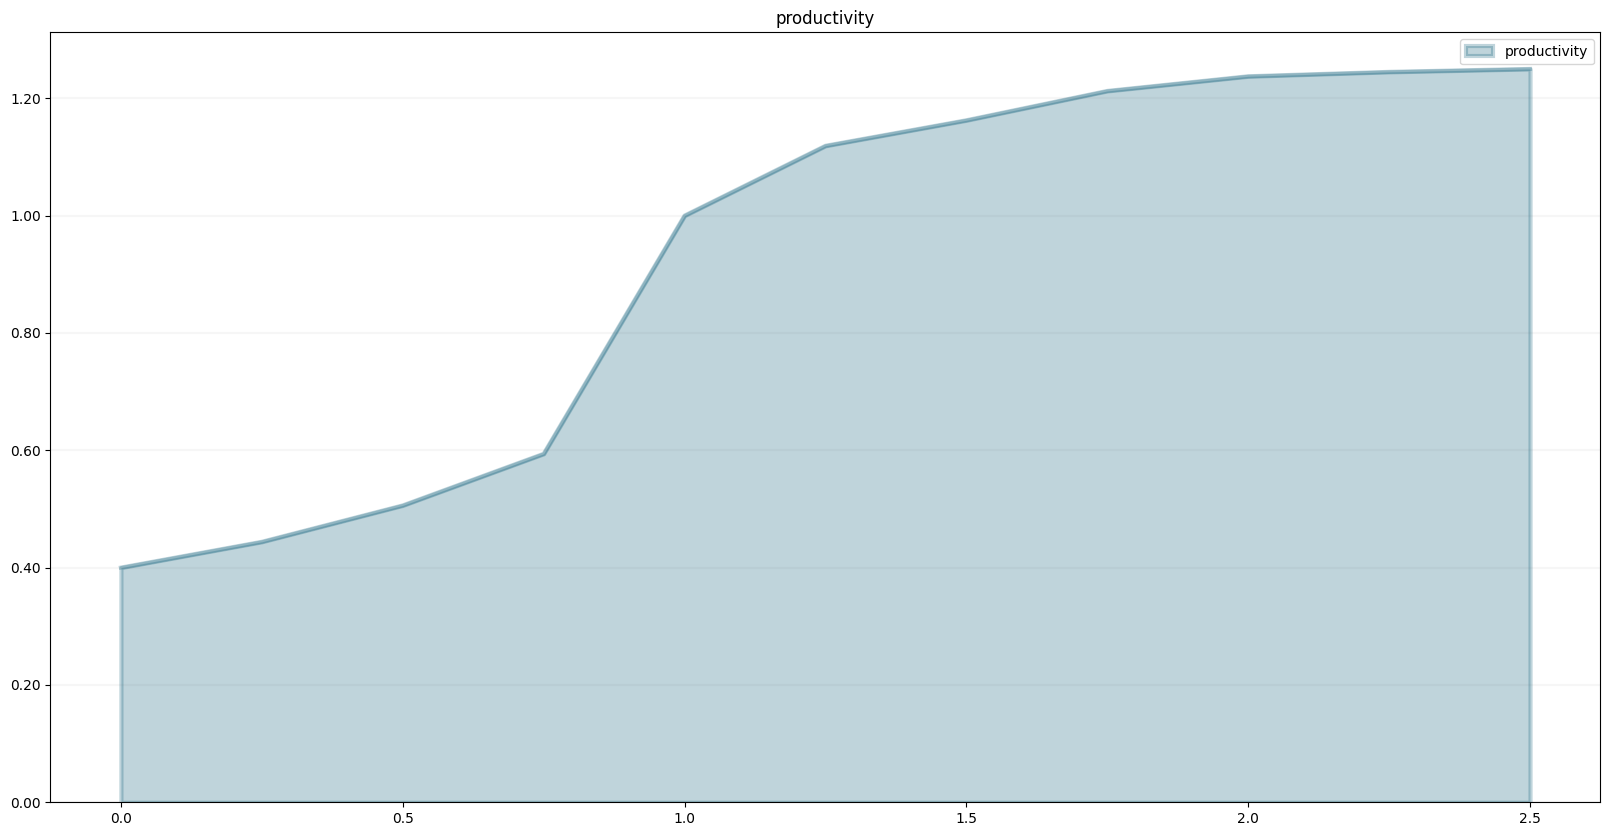

In [13]:
model.plot_lookup("productivity")

The productivity equation is then defined via a lookup function – in our case `productivity` depends non-linearly on `schedulePressure` as defined in the lookup table:

In [14]:
productivity.equation = sd.lookup(schedulePressure,"productivity")

The last equation we need to define is that of the `completionRate` - the completion rate is defined by the number of staff working on the project divided by the effort per task. We then multiply this with the (average) productivity of the staff. The completion rate may never be larger than the number of  `openTasks`, so we constrain it using the `min` function.

In [15]:
completionRate.equation = sd.max(0.0, sd.min(openTasks, staff*(productivity/effortPerTask)))

Now that we have defined all necessary equations, we are ready to run the model. The easist way is to evaluate a model variable at a particular timestep - this approach is particularly useful if you are building the model interactively (e.g. in a Jupyter notebook) and you want to test intermediate results.

In [16]:
closedTasks(80), closedTasks(100), closedTasks(120)

(80.0, 100.0, 100.0)

Let's play with different settings for the deadline:

In [17]:
deadline.equation = 120.0

In [18]:
closedTasks(80), closedTasks(100), closedTasks(120)

(63.33020661244643, 81.06644489208418, 99.99777243819346)

In [19]:
deadline.equation=80.0

In [20]:
closedTasks(80), closedTasks(100), closedTasks(120)

(92.6853060260874, 100.00000000000004, 100.00000000000004)

Of course we can also plot the variables in a graph straight away using the element's  ``plot()`` method.

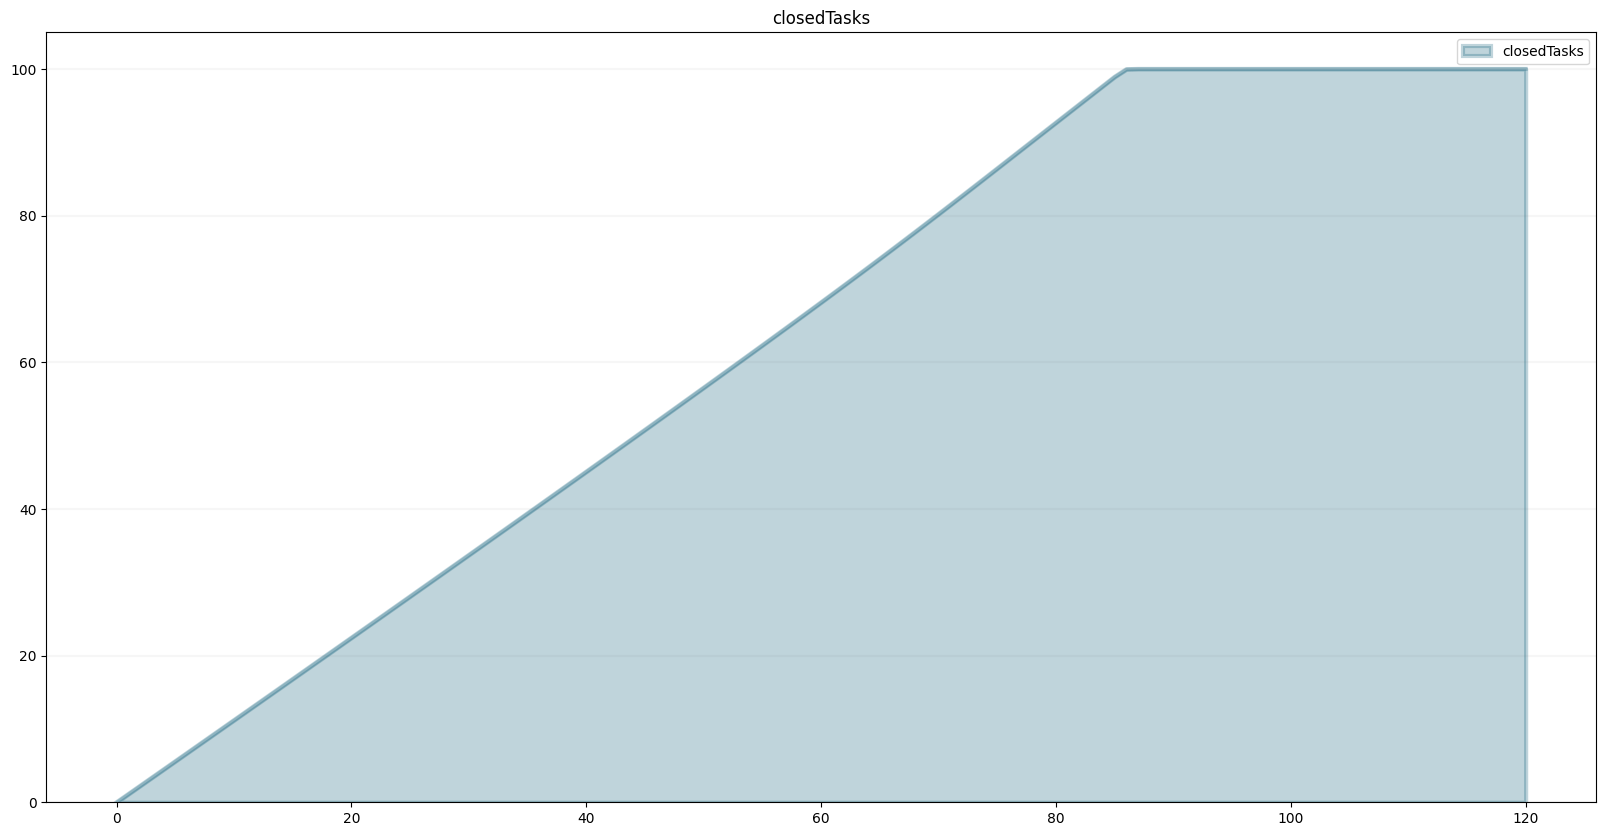

In [21]:
closedTasks.plot()

Now that we have a model, we can use the powerful scenario management built into the BPTK PY framework.

To do that, we first need to instantiate the framework:


In [22]:
import BPTK_Py
bptk = BPTK_Py.bptk()

Then we set up a scenario manager using a Python dictionary. The scenario manager identifies the baseline constants of the model:

In [23]:
scenario_manager = {
    "smSimpleProjectManagementDSL":{
    
    "model": model,
    "base_constants": {
        "deadline": 100.0,
        "initialStaff": 1.0,
        "effortPerTask": 1.0,
        "initialOpenTasks": 100.0,

    },
    "base_points":{
            "productivity": [
                [0.0,0.4],
                [0.25,0.444],
                [0.5,0.506],
                [0.75,0.594],
                [1,1],
                [1.25,1.119],
                [1.5,1.1625],
                [1.75,1.2125],
                [2,1.2375],
                [2.25,1.245],
                [2.5,1.25]
            ]
    }
 }
}

The scenario manager has to be registered as follows:

In [24]:
bptk.register_scenario_manager(scenario_manager)

Once we have this, we can define and register (one or more) scenarios as follows:

In [25]:
bptk.register_scenarios(
    scenarios =
        {
            "scenario80": {
                "constants": {
                    "initialOpenTasks": 80.0
                }
            }
        }
    ,
    scenario_manager="smSimpleProjectManagementDSL")

We can then plot the scenario as follows:

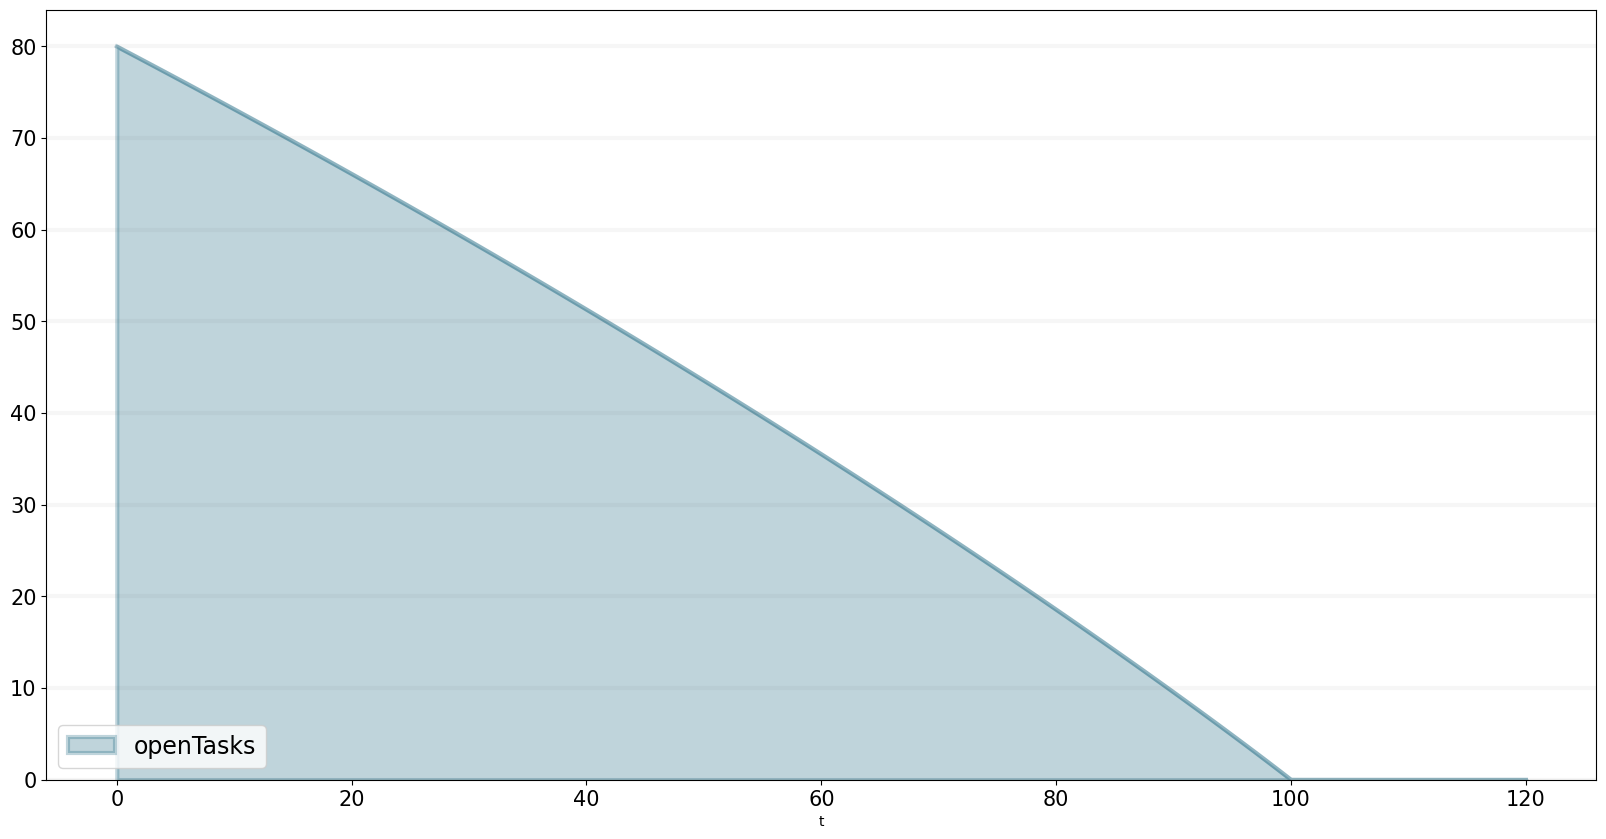

In [26]:
bptk.plot_scenarios(
    scenarios="scenario80",
    scenario_managers="smSimpleProjectManagementDSL",
    equations="openTasks")

Let's register a few more scenarios:

In [27]:
bptk.register_scenarios(
    scenarios =
    {
         "scenario100": {
        
        },
        "scenario120": {
            "constants": {
                "initialOpenTasks" : 120.0
            }
        }
    },
    scenario_manager="smSimpleProjectManagementDSL")

`scenario100` is equivalent to the base settings, hence we don't need to define any settings for it.

Now we can easily compare the scenarios:

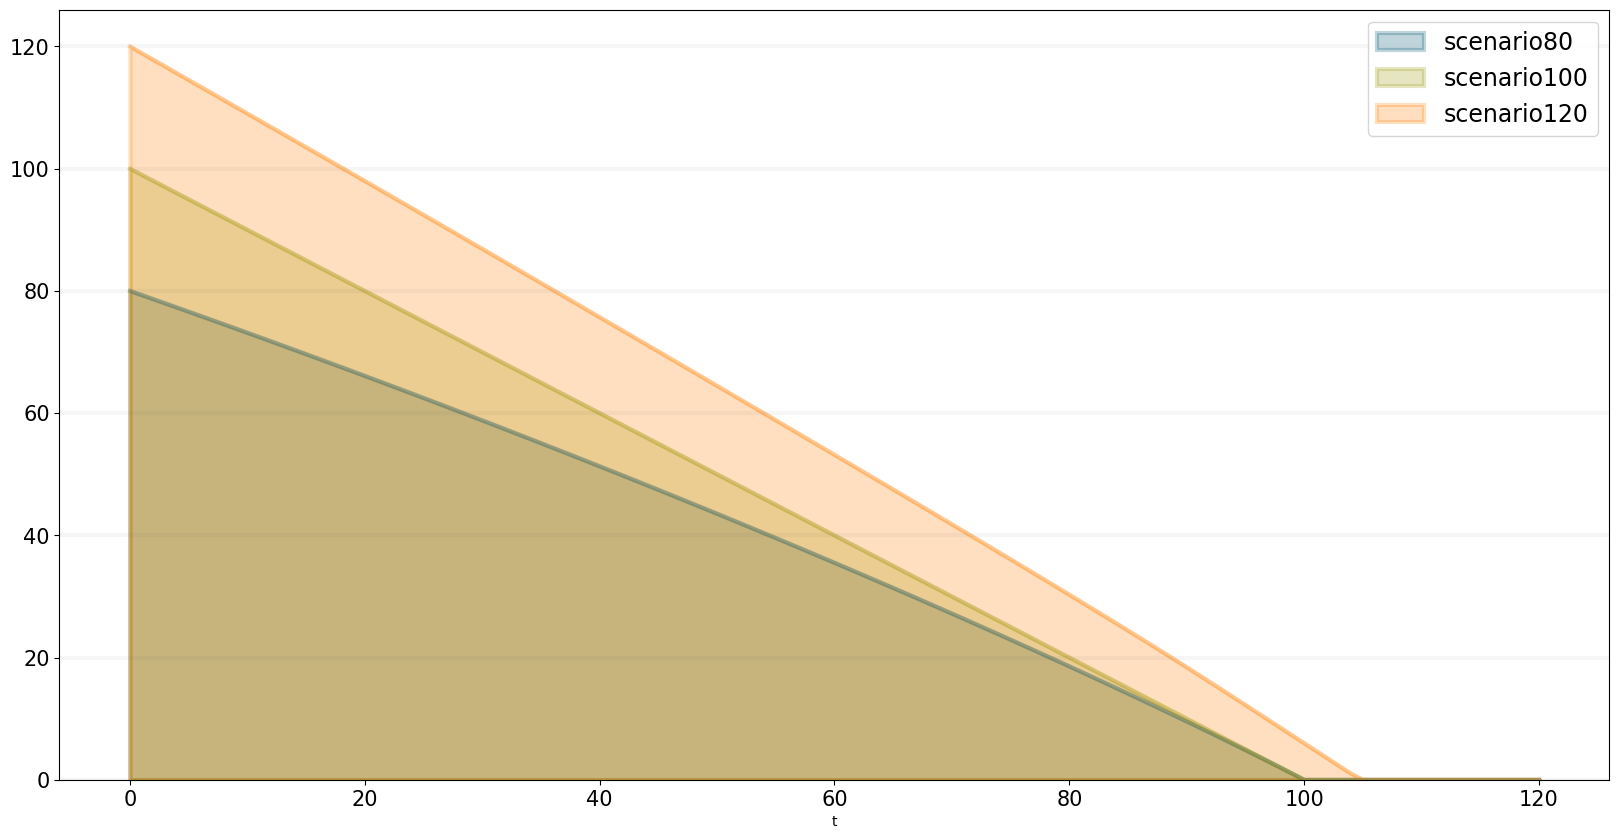

In [28]:
bptk.plot_scenarios(
    scenarios="scenario80,scenario100,scenario120",
    scenario_managers="smSimpleProjectManagementDSL",
    equations="openTasks",
    series_names={
        "smSimpleProjectManagementDSL_scenario80_openTasks":"scenario80",
        "smSimpleProjectManagementDSL_scenario100_openTasks":"scenario100",
        "smSimpleProjectManagementDSL_scenario120_openTasks":"scenario120"
    }
)

## Storing Models Created Using The SD DSL In A Python Class

It is possible to take the code from above and store it in a Python code file. The JSON structure is exactly as you are used to from the generated models. [simulation_models/simple_project_dsl_class.py](simulation_models/simple_project_dsl_class.py) is such a code file that implements the code.
Let us walk through it. For readability, we omit a lot of code and only show the basic structure:
```python

class simulation_model(Model):

    def __init__(self):

        # Never forget calling the super method to initialize the main parameters
        super().__init__(starttime=0,stoptime=120,dt=1,name ='SimpleProjectManagament_scenario80' )

        # Stocks
        openTasks = self.stock("openTasks")
        closedTasks = self.stock("closedTasks")
        staff = self.stock("staff")

        # Flows
        completionRate = self.flow("completionRate")

        # Converters
        currentTime = self.converter("currentTime")
        remainingTime = self.converter("remainingTime")
    
       ...
        # Constants
        deadline = self.constant("deadline")
        effortPerTask = self.constant("effortPerTask")
        
        ...

        # Actual Logic

        openTasks.initial_value = 100.0
        closedTasks.initial_value = 0.0  # not really necessary, but I like to be explicit

        ...

        completionRate.equation = sd.max(0.0, sd.min(openTasks, staff * (productivity / effortPerTask)))
```

First, the class's name has to be ``simulation_model`` and inherit from BPTK_Py.Model, as we have done before. The call to the ``super()._init__`` function configures the model's main parameters. And then only the code for your equations follows. Now you are done, the model is defined.

In the next step, we need to write the JSON (the full file is available here: [scenarios/dsl_class.json](scenarios/dsl_class.json):
```json
{
  "smSimpleProjectManagementDslClass": {
    "model": "simulation_models/simple_project_dsl_class",
    "base_constants": {
      "deadline": 100.0,
      "initialOpenTasks": 100.0
    },
    "base_points": {
      "productivity":  [ [0,0.4],[0.25,0.444],[0.5,0.506],[0.75,0.594],[1,1],[1.25,1.119],[1.5,1.1625],[1.75,1.2125],[2,1.2375],[2.25,1.245],[2.5,1.25] ]
    },
    "scenarios": {
      "scenario100": {
        "constants": {
          "initialOpenTasks": 100.0
        }
      }
    }
  }
}
```
Note that this is exactly the structure we used for linking to the generated SD models. As long as the model has an ``equations`` and ``memo`` field and its name is ``simulation_model``, BPTK-Py is agnostic of the code inside. 

We can easily plot the scenario and see that it the same model as we defined interactively:



In [29]:
import BPTK_Py
bptk = BPTK_Py.bptk()

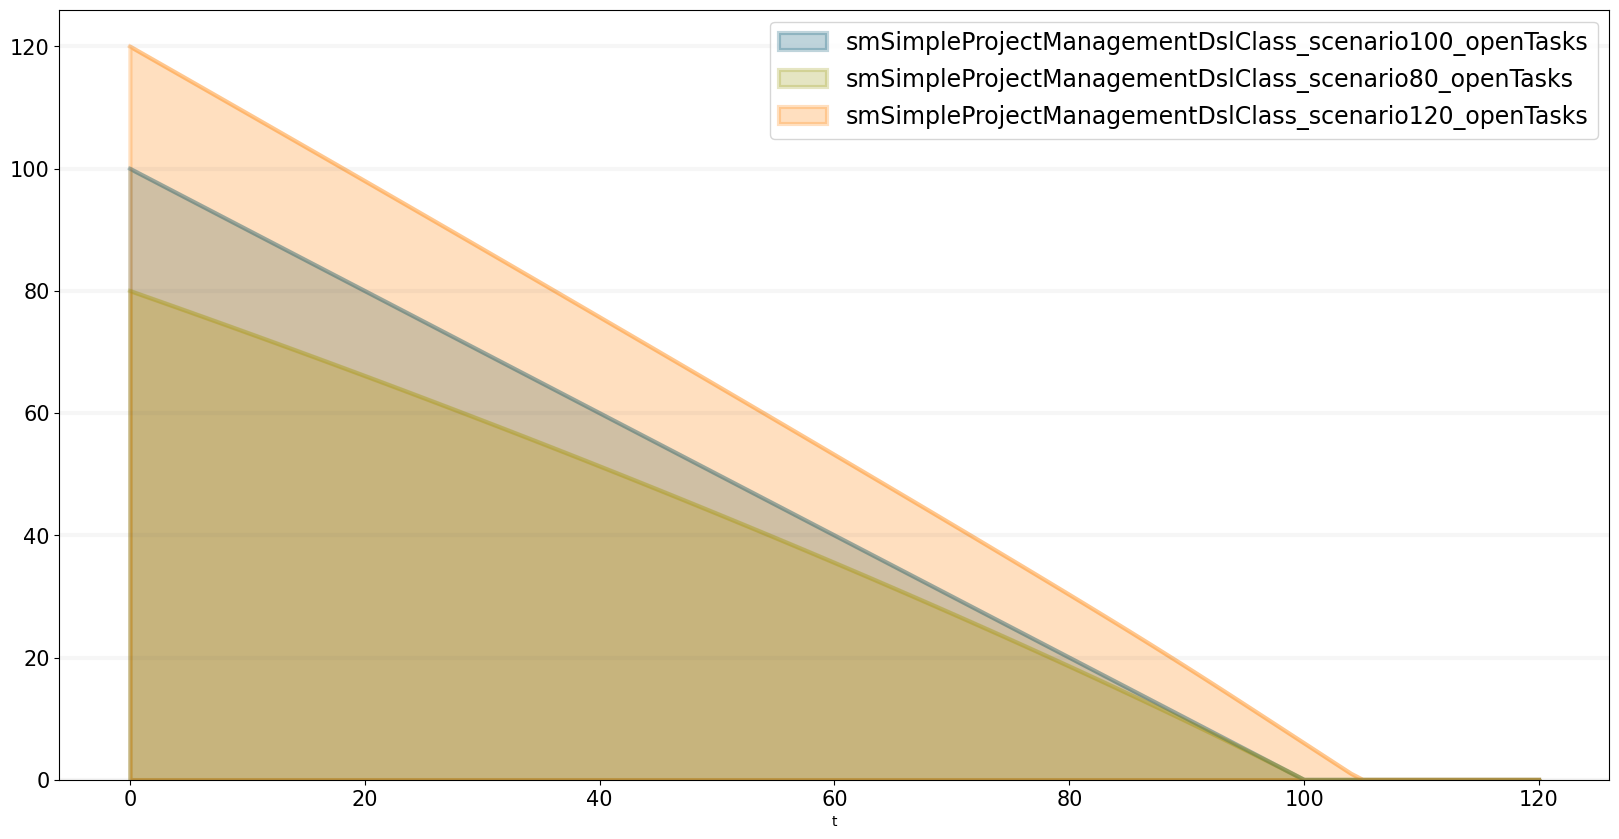

In [30]:
bptk.plot_scenarios(
    scenarios="scenario80,scenario100,scenario120",
    scenario_managers="smSimpleProjectManagementDslClass",
    equations="openTasks",
    series_names={
        "smSimpleProjectManagementDSL_scenario80_openTasks":"scenario80",
        "smSimpleProjectManagementDSL_scenario100_openTasks":"scenario100",
        "smSimpleProjectManagementDSL_scenario120_openTasks":"scenario120"
    }
)

### Conclusion

This completes our quick tour of the SD DSL within the Business Prototyping Toolkit. 

This post introduced a simple domain-specific language for System Dynamics, implemented in Python. It let's you create System Dynamics in Python and supports interactive modeling in Jupyter.

Creating System Dynamics models directly in Python is particulary useful if you have the need to extend your SD models with your own SD functions or you would like to combine your models with other computational models such as Agent-based models or mathematical models.